In [1]:
import msprime
import pyslim
import tskit
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display, SVG

In [3]:
scale = 1
sc_min = 0.001
sc_max = 0.02
rec = 50
anc = 8000

sim_len = 5e3
rho = 1e-8*scale
Ne = 10000

### Bottleneck demo

In [4]:
t_end = 1000 # bottleneck end time
t_start = 2000 # bottleneck start time
N_btnk = 5000

In [7]:
logunif = bool(np.random.randint(2))
if logunif:
    SC = np.exp(np.random.uniform(np.log(sc_min*scale), np.log(sc_max*scale)))
else:
    SC = np.random.uniform(sc_min*scale, sc_max*scale)

# rec = (10**1.2)*(SC**(-0.9)) # for scale = 10
# anc = (10**1.55)*(SC**(-0.9))

mutgen = t_end

while mutgen in [t_start, t_end]: # exclude edge cases
    logunif = bool(np.random.randint(2))
    if logunif:
        mutgen = int(np.exp(np.random.uniform(np.log(rec), np.log(anc))))
    else:
        mutgen = np.random.randint(rec, anc) # scaled generation of selection onset (before present)

In [8]:
SC, mutgen

(0.0020126969717015495, 141)

In [9]:
demography = msprime.Demography()

In [10]:
extant_indvs = int(Ne/scale)
if mutgen >= t_start:
    demography.add_population(name="A", initial_size=extant_indvs)
elif mutgen < t_end:
    demography.add_population(name="A", initial_size=extant_indvs)
    demography.add_population_parameters_change(time=int((t_end-mutgen)/scale), population="A", initial_size=int(N_btnk/scale))
    demography.add_population_parameters_change(time=int((t_start-mutgen)/scale), population="A", initial_size=int(Ne/scale))
else:
    extant_indvs = int(N_btnk/scale)
    demography.add_population(name="A", initial_size=extant_indvs)
    demography.add_population_parameters_change(time=int((t_start-mutgen)/scale), population="A", initial_size=int(Ne/scale))

In [11]:
demography

Demography(populations=[Population(initial_size=10000, growth_rate=0, name='A', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0)], events=[PopulationParametersChange(time=859, initial_size=5000, growth_rate=None, population='A'), PopulationParametersChange(time=1859, initial_size=10000, growth_rate=None, population='A')], migration_matrix=array([[0.]]))

In [12]:
demography.debug()

,start,end,growth_rate
A,10000.0,10000.0,0
time,type,parameters,effect
859,Population parameter change,"population=A, initial_size=5000",initial_size → 5e+03 for population A
,start,end,growth_rate
A,5000.0,5000.0,0
time,type,parameters,effect
1859,Population parameter change,"population=A, initial_size=10000",initial_size → 1e+04 for population A
,start,end,growth_rate
A,10000.0,10000.0,0


In [13]:
ts_init = msprime.sim_ancestry(samples=extant_indvs,
                               demography=demography,
                               sequence_length=sim_len,
                               recombination_rate=rho)

In [14]:
ts_init.num_individuals

10000

In [15]:
ts_init.num_samples

20000

In [16]:
list(ts_init.populations())

[Population(id=0, metadata={'description': '', 'name': 'A'})]

In [17]:
center_gen = ts_init.at(sim_len/2)

In [18]:
subtree_size = np.empty((len(list(center_gen.nodes())), 2), dtype=int) # node_id | total leaves

In [19]:
subtree_size.shape

(39999, 2)

In [20]:
for idx, nd in enumerate(center_gen.nodes()):
    for samp_nd in center_gen.samples(nd):
        assert center_gen.population(samp_nd) == 0
    subtree_size[idx] = [nd, center_gen.num_samples(nd)] ## samples, not individuals

In [ ]:
subtree_size # node_id | total leaves

In [ ]:
np.unique(subtree_size[:,1], return_counts=True)

In [21]:
intNode_AF = subtree_size[:,1]/(2*extant_indvs)

In [ ]:
hist, bins, _ = plt.hist(intNode_AF, bins=50)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

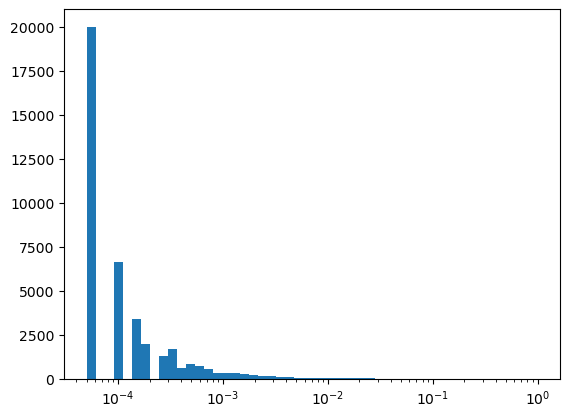

In [23]:
plt.hist(intNode_AF, bins=logbins)
plt.xscale('log')
plt.show()

In [24]:
AF_thr = np.random.uniform(0.01, 0.1)

In [25]:
mut_nd_idx = np.abs(intNode_AF - AF_thr).argmin()

In [26]:
mut_nd_idx

11969

In [27]:
AF_init = intNode_AF[mut_nd_idx]

In [28]:
subtree_size[mut_nd_idx], AF_init

(array([39429,   227]), 0.01135)

In [29]:
test_pref = "test0614aft"

In [30]:
np.savetxt(f"{test_pref}.param", [sim_len, SC, mutgen, AF_init, t_start, t_end, N_btnk], fmt='%f')

In [31]:
mut_nd = subtree_size[mut_nd_idx, 0]
ts_init.node(mut_nd)

Node(id=39429, flags=0, time=66.10211856681542, population=0, individual=-1, metadata=b'')

In [32]:
np.ceil(ts_init.node(mut_nd).time)

67.0

In [33]:
init_tables = ts_init.dump_tables()

In [34]:
init_tables

In [35]:
init_tables.sites.add_row(position=sim_len/2, ancestral_state="A")

0

In [36]:
init_tables.mutations.add_row(site=0, node=mut_nd, derived_state="T", time=int(np.ceil(ts_init.node(mut_nd).time)))

0

In [37]:
max(init_tables.nodes.population)

0

In [38]:
init_tables.sites

id,position,ancestral_state,metadata
0,2500,A,


In [39]:
init_tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,39429,67,T,-1,


In [40]:
ts_init_mut = init_tables.tree_sequence()

In [41]:
ts_init_mut = pyslim.annotate(ts_init_mut, model_type="WF", tick=1, stage="late")

In [42]:
ts_init_mut.genotype_matrix().sum()

227

In [43]:
ts_init_mut.dump(f"{test_pref}.trees")

In [ ]:
SVG(ts_init_mut.at(sim_len/2).draw_svg(
    size=(500, 500),
    y_gridlines=True,
    y_axis=True,
    #tree_height_scale="log_time",
    #node_labels={},    # Remove all node labels for a clearer viz
    #style=css_string,  # Apply the stylesheet
))

#### Overlay mutations

In [ ]:
ts_slim = pyslim.load("testinf_slim.trees")

In [ ]:
ts_slim

In [ ]:
max(t.num_roots for t in ts_slim.trees())

In [ ]:
ts_slim.tables.mutations[0]

In [ ]:
ts_slim.tables.populations

In [ ]:
alive = ts_slim.individuals_alive_at(0)

print(f"There are {len(alive)} individuals alive from the final generation.")

num_alive = [0 for _ in range(ts_slim.num_populations)]
for i in alive:
    ind = ts_slim.individual(i)
    num_alive[ind.population] += 1

for pop, num in enumerate(num_alive):
    print(f"Number of individuals in population {pop}: {num}")

In [ ]:
pop_indivs = [[], [], []]
for i in ts_slim.individuals_alive_at(0):
    ind = ts_slim.individual(i)
    pop_indivs[ind.population].append(i)

In [ ]:
len(pop_indivs[0]), len(pop_indivs[1]), len(pop_indivs[2])

In [ ]:
keep_indivs = np.random.choice(pop_indivs[1], 16, replace=False)
keep_nodes = []
for i in keep_indivs:
    keep_nodes.extend(ts_slim.individual(i).nodes)
sts = ts_slim.simplify(keep_nodes)

In [ ]:
print(f"Before, there were {ts_slim.num_samples} sample nodes (and {ts_slim.num_individuals} individuals) "
       f"in the tree sequence, and now there are {sts.num_samples} sample nodes "
       f"(and {sts.num_individuals} individuals).")

In [ ]:
sts

In [ ]:
msprime.mutate(sts, rate=1e-9*10, keep=True)

In [ ]:
sts = pyslim.load("testtru_samp.trees")

In [ ]:
SVG(sts.at(5e4).draw_svg(
    size=(500, 500),
    y_gridlines=True,
    y_axis=True,
    #tree_height_scale="log_time",
    #node_labels={},    # Remove all node labels for a clearer viz
    #style=css_string,  # Apply the stylesheet
))

In [ ]:
SVG(sts.at(5e4).draw_svg(
    size=(500, 500),
    y_gridlines=True,
    y_axis=True,
    #tree_height_scale="log_time",
    #node_labels={},    # Remove all node labels for a clearer viz
    #style=css_string,  # Apply the stylesheet
))

In [ ]:
wide_fmt = (1200, 250)

styles = []
# Create a style for each population, programmatically (or just type the string by hand)
for colour, p in zip(['red', 'green', 'blue'], samp_ts.populations()):
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
    #print(f'"{s}" applies to nodes from population {p.metadata["name"]} (id {p.id})')
css_string = " ".join(styles)
print(f'CSS string applied:\n    "{css_string}"')

SVG(samp_ts.at(5e4).draw_svg(
    size=wide_fmt,
    tree_height_scale="log_time",
    y_gridlines=True,
    y_axis=True,
    node_labels={},    # Remove all node labels for a clearer viz
    style=css_string,  # Apply the stylesheet
))

In [ ]:
plt.hist(pop_noSamps[pop_noSamps[:, 1] == 1][:, 2])

### Neutral sims in msprime

In [3]:
scale = 1
N = 16
rho = 1e-8*scale
sim_len = 1e4

In [ ]:
demography = msprime.Demography()
## Tru

N_B = 50000
N_C = 10000
N_BC = 20000

demography.add_population(name="B", initial_size=int(N_B/scale))
demography.add_population(name="C", initial_size=int(N_C/scale))
demography.add_population(name="BC", initial_size=int(N_BC/scale))

demography.set_migration_rate(source="C", dest="B", rate=0.001)
demography.set_migration_rate(source="B", dest="C", rate=0.0001)

demography.add_population_parameters_change(time=int(8000/scale), population="C", initial_size=5000)
demography.add_migration_rate_change(time=int(8000/scale), source="C", dest="B", rate=0.01)
demography.add_migration_rate_change(time=int(8000/scale), source="B", dest="C", rate=0)

demography.add_population_split(time=int(9000/scale), derived=["B", "C"], ancestral="BC")

In [ ]:
demography = msprime.Demography()
## Inf

N_B = 30281
N_C = 10100
N_BC = 33980
N_ABC = 11593

tau_BC = 845
tau_ABC = 17937
mig_B2C = 0.0002148

demography.add_population(name="B", initial_size=int(N_B/scale))
demography.add_population(name="C", initial_size=int(N_C/scale))
demography.add_population(name="BC", initial_size=int(N_BC/scale))

demography.set_migration_rate(source="C", dest="B", rate=mig_B2C)

demography.add_population_split(time=int(tau_BC/scale), derived=["B", "C"], ancestral="BC")
demography.add_population_parameters_change(time=int(tau_ABC/scale), population="BC", initial_size=N_ABC)

In [ ]:
demography

In [ ]:
ts_init = msprime.sim_ancestry(samples={"B":int(N_B/scale), "C":int(N_C/scale)},
                               demography=demography,
                               sequence_length=sim_len,
                               recombination_rate=rho)

In [ ]:
ts_init

In [ ]:
ts_init.tables.populations

In [ ]:
center_gen = ts_init.at(sim_len/2)
pop_noSamps = np.empty((len(list(center_gen.nodes())), 5), dtype=int) # node_id | population | total leaves | B leaves | C leaves
for idx, nd in enumerate(center_gen.nodes()):
    pop_samp_count = [0, 0] # B_cnt, C_cnt
    for samp_nd in center_gen.samples(nd):
        pop_samp_count[center_gen.population(samp_nd)] += 1
    pop_noSamps[idx] = [nd, center_gen.population(nd), center_gen.num_samples(nd)] + pop_samp_count ## samples, not individuals

In [ ]:
pop_noSamps.shape

In [ ]:
AF_isl = pop_noSamps[:, 4]/(2*N_C/scale)
AF_thr = np.random.uniform(0.2, 0.95)
mut_nd_idx = np.abs(AF_isl - AF_thr).argmin()

In [ ]:
AF_init = pop_noSamps[mut_nd_idx, 4]/(2*N_C/scale)
AF_B = pop_noSamps[mut_nd_idx, 3]/(2*N_B/scale)
AF_tot = pop_noSamps[mut_nd_idx, 2]/(2*(N_B+N_C)/scale)
mut_nd = pop_noSamps[mut_nd_idx, 0]

In [ ]:
AF_thr, AF_init

In [ ]:
print("Mutation @ node:", ts_init.node(mut_nd))
print(pop_noSamps[mut_nd_idx])

In [ ]:
init_tables = ts_init.dump_tables()
init_tables.sites.add_row(position=sim_len/2, ancestral_state="A")
init_tables.mutations.add_row(site=0, node=mut_nd, derived_state="T", time=int(np.ceil(ts_init.node(mut_nd).time)))

In [ ]:
ts = init_tables.tree_sequence() # ts with mutation overlaid

In [ ]:
ts

In [ ]:
print(f"Max roots: {max(t.num_roots for t in ts.trees())}")

In [ ]:
print(len(ts.samples()), len(ts.samples(population=0)), len(ts.samples(population=1)), len(ts.samples(population=2)))

In [ ]:
ts.samples(population=1)

In [ ]:
keep_nodes = np.random.choice(ts.samples(population=1), 2*N, replace=False)

In [ ]:
keep_nodes.shape

In [ ]:
sts = ts.simplify(keep_nodes)

In [ ]:
print(f"Simplify: {ts.num_samples}/{ts.num_individuals} -> {sts.num_samples}/{sts.num_individuals}")

In [ ]:
print(f"Region_len:{sim_len}\tAF (C, B, tot):{AF_init}/{AF_B}/{AF_tot}")

In [25]:
sim_len = 1e5
sts = tskit.load("test0_samp.trees")

In [26]:
sts.genotype_matrix().mean()

0.6875

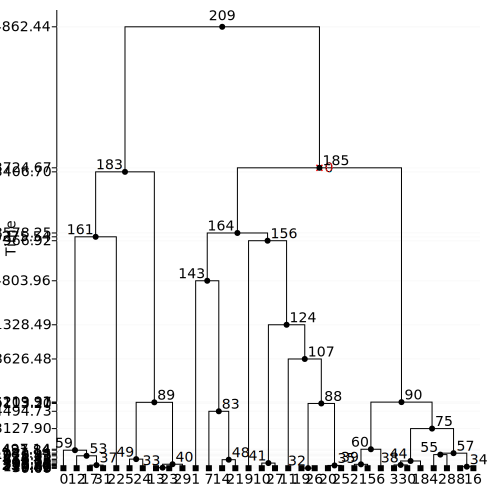

In [27]:
SVG(sts.at(sim_len/2).draw_svg(
    size=(500, 500),
    y_gridlines=True,
    y_axis=True,
    #tree_height_scale="log_time",
    #node_labels={},    # Remove all node labels for a clearer viz
    #style=css_string,  # Apply the stylesheet
))

In [21]:
13135.10


13135.1